# Multiple Observation SocialDilemma

> Class for a symmetric two-agent stateless social dilemma environment

Typical examples are the *Prisoner's Dilemma*, *Stag Hunt* game, and the game of *chicken*/*snowdrift*/*hawk-dove*.

In [1]:
#| default_exp Environments/MultipleObsSocialDilemma

In [2]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

In [4]:
#| export
from pyCRLD.Environments.Base import ebase

from fastcore.utils import *
from fastcore.test import *

from pyCRLD.Environments.HeterogeneousObservationsEnv import HeterogeneousObservationsEnv

import numpy as np

In [42]:
#| export
class MultipleObsSocialDilemma(HeterogeneousObservationsEnv):
    """
    Symmetric 2-agent 2-action Social Dilemma Matrix Game.
    """
    def __init__(self,
                 rewards, # reward of mutual cooperation
                 temptations, # temptation of unilateral defection
                 suckers_payoffs, # sucker's payoff of unilateral cooperation
                 punishments, # punishment of mutual defection
                 contract_probability = 0.5, # probability for contract
                 observation_opacity=None): # partial or full observability

        # Validate each attribute to ensure it is either an integer or a list of two integers
        def validate_attribute(attribute):
            if isinstance(attribute, list) and len(attribute) == 2:
                return attribute
            elif isinstance(attribute, (int, float, complex)):
                print('size of attr list', attribute)
                return [attribute]
            else:
                raise ValueError("Attribute must be a single integer or a list of two integers.")
        
        # Applying the validation to each attribute
        self.rewards = validate_attribute(rewards)
        self.temptations = validate_attribute(temptations)
        self.suckers_payoffs = validate_attribute(suckers_payoffs)
        self.punishments = validate_attribute(punishments)

        # TODO: these variables are expected to be already initialized in the parent class
        # causing a recursive calling and causing the dependency on them to fail
        # therefore we need to initialize them here
        self.n_agents = 2
        self.n_agent_actions = 2
        self.n_states = len(self.rewards)
        
        self.observation_opacity = observation_opacity
        # This adds a dynamic aspect to the game where the outcome can also depend on the evolving 
        # relationship state (contract or no contract).
        # A state can be either contracted or not, or have the default state '.'. The contract indicate whether
        # there is an agreement or alignment between the agents, which could influence their strategic decisions.
        self.contract_probability = contract_probability  # probability for contract
        self.state = 0 # initial state
        
        super(MultipleObsSocialDilemma, self).__init__(observation_opacity=observation_opacity)

In [6]:
#| export
@patch
def transition_tensor(self:MultipleObsSocialDilemma):
    """Calculate the Transition Tensor"""
    if self.n_states == 1:
        print('🌸')
        Tsas = np.ones((self.n_states, self.n_agent_actions, self.n_agent_actions, self.n_states))
    # Case for contract/no-contract states
    else:
        print('☀️')
        Tsas = np.ones((self.n_states, self.n_agent_actions, self.n_agent_actions, self.n_states)) * (-1)
        Tsas[:, :, :, 0] = 1 - self.contract_probability
        Tsas[:, :, :, 1] = self.contract_probability
    return Tsas

@patch
def reward_tensor(self:MultipleObsSocialDilemma):
    """Get the Reward Tensor R[i,s,a1,...,aN,s']."""

    R = np.zeros((self.n_agents, self.n_states, self.n_agent_actions, self.n_agent_actions, self.n_states))

    if self.n_states == 1:
        R[0, 0, :, :, 0] = [[self.rewards[0], self.suckers_payoffs[0]],
                            [self.temptations[0], self.punishments[0]]]
        R[1, 0, :, :, 0] = [[self.rewards[0], self.temptations[0]],
                            [self.suckers_payoffs[0], self.punishments[0]]]
    else:
        # set reward matrix for agents in first (no-contract) state
        R[0, 0, :, :, 0] = [[self.rewards[0], self.suckers_payoffs[0]],
                            [self.temptations[0], self.punishments[0]]]
        R[1, 0, :, :, 0] = [[self.rewards[0], self.temptations[0]],
                            [self.suckers_payoffs[0], self.punishments[0]]]
        R[:, 0, :, :, 1] = R[:, 0, :, :, 0]
    
        # set reward matrix for agents the second (contract) state
        R[0, 1, :, :, 1] = [[self.rewards[1], self.suckers_payoffs[1]],
                            [self.temptations[1], self.punishments[1]]]
        R[1, 1, :, :, 1] = [[self.rewards[1], self.temptations[1]],
                            [self.suckers_payoffs[1], self.punishments[1]]]
        R[:, 1, :, :, 0] = R[:, 1, :, :, 1]
        
    return R


@patch
def actions(self:MultipleObsSocialDilemma):
    """The action sets"""
    return [['c', 'd'] for _ in range(self.n_agents)]

@patch
def states(self:MultipleObsSocialDilemma):
    """The states set"""
    # Check whether the game has 2 rewards, this is equivalent of checking any of the
    # other game values and equivalent to checking if the number of states should be 2
    if self.n_states == 2:
        print("contract 2 states")
        return [0, 1], ["no contract", "contract"]
    # Otherwise we default to the unique IPD state
    else:
        return ['.']

@patch
def id(self:MultipleObsSocialDilemma):
    """
    Returns id string of environment
    """
    # Default
    id = f"{self.__class__.__name__}_"+\
        f"{self.temptations}_{self.rewards}_{self.punishments}_{self.suckers_payoffs}"
    return id

In [7]:
#| hide
import nbdev; nbdev.nbdev_export()

### Example

In [15]:
env_full_obs = MultipleObsSocialDilemma(rewards=1, temptations=2, suckers_payoffs=-1, punishments=0, observation_opacity=[0, 0])

# TODO: if opacity = observation_opacity=[0.7, 0])
# resulting matrix still is 
# array([[[0.5, 0.5],
#         [0.5, 0.5]],

#        [[1. , 0. ],
#         [0. , 1. ]]])
# but it'd be cool if this is percentage of how much an agent can see back in the past or not
# as if it was a percentage... of the amount of things they can see

# TODO: there's another problem
# if opacity = observation_opacity=[0.2, 0])
# the matrix adjusts like this
# array([[[0.8, 0.2],
#         [0.2, 0.8]],

#        [[1. , 0. ],
#         [0. , 1. ]]])
# However, I've just realized this matrix is not about percentages of probabibilities of seeing
# things, but it's the actual seeing. Meaning if they're confused about the environment and have
# partial vision they should have 0.5 everywhere. This should be a simple bug to fix I just have to
# reset the behavior for when it's smaller than 0.5 to be the same for when it's equal to bigger than
# 0.5

size of attr list 1
size of attr list 2
size of attr list -1
size of attr list 0
🌸
for agent  0
confidence is , 0
2 1 1
for agent  1
confidence is , 0
2 1 1


In [16]:
env_full_obs.observations

array([[[1.]],

       [[1.]]])

In [17]:
env_full_obs.rewards

array([[[[[ 1.],
          [-1.]],

         [[ 2.],
          [ 0.]]]],



       [[[[ 1.],
          [ 2.]],

         [[-1.],
          [ 0.]]]]])

In [20]:
env_full_obs.observation_set

[['.'], ['.']]

### Testing MultipleObsSocialDilemma under full homogeneous observability conditions:

In [21]:
from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Utils import FlowPlot as fp

# This code is equivalent to the one under EnvUncertainDilemma
env_fullObs = MultipleObsSocialDilemma(rewards=[5, 5], temptations=[6, 2], suckers_payoffs=[-1, -1], punishments=[0, 0], contract_probability=0.5, observation_opacity=[0, 0])
mae_fullObs = POstratAC(env=env_fullObs, learning_rates=0.1, discount_factors=0.9)

☀️
for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 0
2 2 2
contract 2 states


array([<Axes: title={'center': 'Cond. 0'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'Cond. 1'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

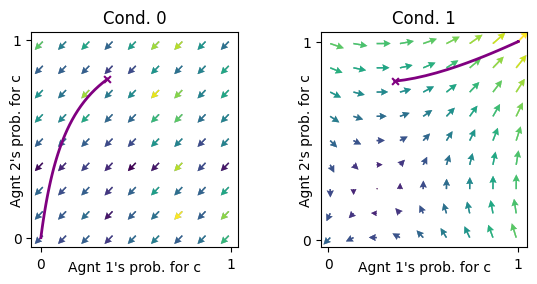

In [22]:
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)
xtraj, fixedpointreached = mae_fullObs.trajectory(X)

x = ([0], [0,1], [0])  # Plotting on the x-axis the [0]'s agents probability in both observations [0,1] to cooprate [0]
y = ([1], [0,1], [0])  # Plotting on the y-axis the [1]'s agents probability in both observations [0,1] to cooprate [0]
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

### Testing MultipleObsSocialDilemma under partial homogeneous observability conditions:

size of attr list 5
size of attr list 6
size of attr list -1
size of attr list 0
🌸
for agent  0
confidence is , 1
2 1 1
for agent  1
confidence is , 1
2 1 1


[<Axes: >]

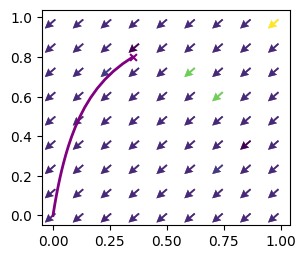

In [23]:
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)

env_randObs = MultipleObsSocialDilemma(rewards=5, temptations=6, suckers_payoffs=-1, punishments=0, contract_probability=0.5, observation_opacity=[1, 1])
mae_randObs = POstratAC(env=env_randObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_randObs.trajectory(X)


x = ([0], [0], [0])  # Plotting on the x-axis the [0]'s agents probability to cooprate [0]
y = ([1], [0], [0])  # Plotting on the y-axis the [1]'s agents probability to cooprate [0]

ax = fp.plot_strategy_flow(mae_randObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

In [24]:
env_randObs.O

array([[[1.]],

       [[1.]]])

### Testing MultipleObsSocialDilemma under partial heterogeneous observability conditions:

☀️
for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 0.5
2 2 2
contract 2 states


array([<Axes: title={'center': 'Cond. 0'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'Cond. 1'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

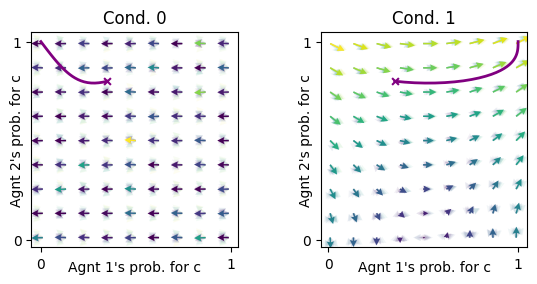

In [25]:
env_partial_hetero_obs = MultipleObsSocialDilemma(rewards=[5, 5], temptations=[6, 2], suckers_payoffs=[-1, -1], punishments=[0, 0], contract_probability=0.5, observation_opacity=[0, 0.5])
mae_fullObs = POstratAC(env=env_partial_hetero_obs, learning_rates=0.1, discount_factors=0.9)
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)
xtraj, fixedpointreached = mae_fullObs.trajectory(X)

x = ([0], [0, 1], [0])  # Plotting on the x-axis the [0]'s agents probability in both observations [0,1] to cooprate [0]
y = ([1], [0, 1], [0])  # Plotting on the y-axis the [1]'s agents probability in both observations [0,1] to cooprate [0]
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

In [26]:
env_partial_hetero_obs.O

array([[[1. , 0. ],
        [0. , 1. ]],

       [[0.5, 0.5],
        [0.5, 0.5]]])

### Test history with full homogeneous observability history: 

In [27]:
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded, ObsActHistsIx, hOset

In [28]:
env_full_obs_homo = MultipleObsSocialDilemma(rewards=5, temptations=6, suckers_payoffs=-1, punishments=0, contract_probability=0.5, observation_opacity=[1, 1])
# env_full_obs_homo.Sset = ['.']
memo1pd = HistoryEmbedded(env_full_obs_homo, h=(1,1,1))

size of attr list 5
size of attr list 6
size of attr list -1
size of attr list 0
🌸
for agent  0
confidence is , 1
2 1 1
for agent  1
confidence is , 1
2 1 1


In [29]:
env_full_obs_homo.Aset

[['c', 'd'], ['c', 'd']]

In [30]:
env_full_obs_homo.Oset

[['.'], ['.']]

In [31]:
memo1pd.Sset

['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']

In [32]:
memo1pd.O

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

In [33]:
memo1pd.Oset

[['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|'],
 ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']]

In [34]:
ObsActHistsIx(memo1pd, (1,1,1))

[(0, 0, 0), (0, 1, 1)]

In [35]:
# TODO: pretending I've fixed the issue, the bug is still happening meaning I have to investigate further
# The issue is:
# The observations sets are being built like this
# [['c,c,[1.]|', 'c,d,[1.]|', 'd,c,[1.]|', 'd,d,[1.]|'],
# This is likely some problem with the environment and to how I create this set in there

# memo1pd.Oset = [['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|'],
#  ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']]

In [36]:
memo1pd.O

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

In [37]:
hOset(memo1pd, (1,1,1))

[['c,c,c,c,.||', 'c,d,c,d,.||'], ['c,c,c,c,.||', 'c,d,c,d,.||']]

In [38]:
# mae1 = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
mae1 = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])

 [plot] generating data 99 %   

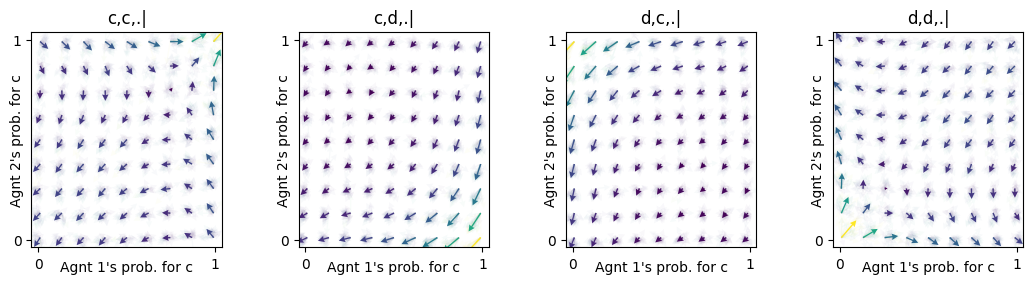

In [39]:
ax = fp.plot_strategy_flow(mae1, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=mae1.env.Sset, verbose=True)

# TODO: the number of conditions is wrong due to some mismatch in the hOset method implementation
# I need to keep in mind when fixing it that I shouldn't break backward compatibility with AC agents
# I need to fix it for POSAC

### Test history with partial homogeneous observability history: 

In [43]:
env_full_obs_homo = MultipleObsSocialDilemma(rewards=1, temptations=1.2, suckers_payoffs=-0.5, punishments=0, contract_probability=0.5, observation_opacity=[1, 0.5])
# (R=1.0, T=1.2, S=-0.5, P=0.0)
# env_full_obs_homo.Sset = ['.']
# memo1pd = HistoryEmbedded(env_full_obs_homo, h=(1,1,1))

size of attr list 1
size of attr list 1.2
size of attr list -0.5
size of attr list 0


NotImplementedError: 

In [ ]:
np.allclose(env_full_obs_homo.O.sum(-1), 1)

In [ ]:
env_full_obs_homo.Sset

In [ ]:
env_full_obs_homo.Oset

In [ ]:
env_full_obs_homo.O

In [41]:
memo1pd = HistoryEmbedded(env_full_obs_homo, h=(1,1,1))

In [ ]:
memo1pd.Oset

In [ ]:
mae1 = POstratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])

In [ ]:
mae1.env.Sset

In [ ]:
mae1.env.Oset

In [ ]:
mae1.env.O[0] = [[0.25, 0. , 0. , 0. ],
                [0. , 0.25, 0. , 0. ],
                [0. , 0. , 0.25, 0. ],
                [0. , 0. , 0. , 0.25]]

In [ ]:
ax = fp.plot_strategy_flow(mae1, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=mae1.env.Sset, verbose=True)

# TODO: the number of conditions is wrong due to some mismatch in the hOset method implementation
# I need to keep in mind when fixing it that I shouldn't break backward compatibility with AC agents
# I need to fix it for POSAC

In [ ]:
memo1pd.O

### Test history with partial heterogeneous observability history: 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()